In [21]:
# Import libraries
import os
import cv2
import imghdr
import tensorflow as tf
import numpy as np

from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [22]:
# Set directories
root_dir = os.getcwd()
data_dir = os.path.join(root_dir, "mosquitoes-dataset")

Process images

In [23]:
IMG_SIZE = (160, 160)
image_ext = ['jpeg', 'jpg', 'png']

In [24]:
image_class = os.listdir(data_dir)

In [25]:
# Remove corrupted images
for label in image_class:
    for image in os.listdir(os.path.join(data_dir, label)):
        image_path = os.path.join(data_dir, label, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_ext:
                print("Image not in extensions list {}" .format(image_path))
                os.remove(image_path)
        except Exception as e:
            print("Issue with image {}" .format(image_path))
            os.remove(image_path)

In [26]:
# Data normalization
normalize = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
])

In [27]:
# Data preparation wrapper
AUTOTUNE = tf.data.AUTOTUNE


def prepare(ds):
    ds = ds.map(lambda x, y: (normalize(x), y),
                num_parallel_calls=AUTOTUNE)
    ds.cache()
    ds.prefetch(buffer_size=AUTOTUNE)
    return ds

Create dataset

In [28]:
# Load data using Keras
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                               image_size=IMG_SIZE,
                                                               seed=1234,
                                                               batch_size=16,
                                                               validation_split=0.2,
                                                               subset='both',
                                                               )

Found 1201 files belonging to 2 classes.
Using 961 files for training.
Using 240 files for validation.


In [29]:
# List of classes
class_names = train_ds.class_names

In [30]:
train_ds = prepare(train_ds)
val_ds = prepare(val_ds)

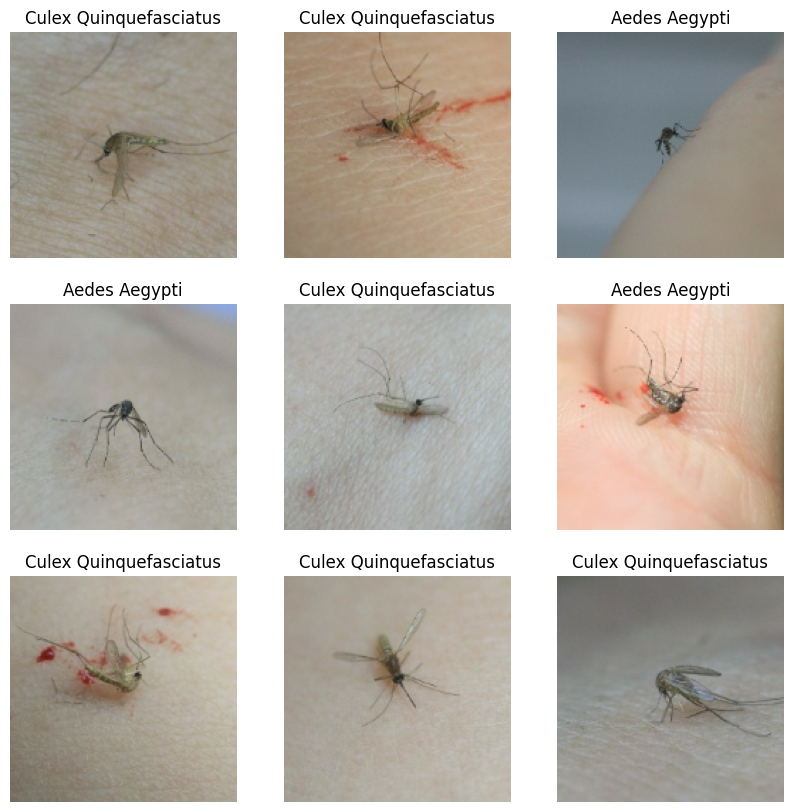

In [31]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")

Build model

In [32]:
model = Sequential()

In [33]:
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(160, 160, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [34]:
base_learning_rate = 1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              )

In [35]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 158, 158, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 79, 79, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 77, 77, 16)        2320      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 38, 38, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 36, 36, 16)        2320      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 18, 18, 16)       

Train model

In [36]:
hist = model.fit(train_ds,
                 epochs=10,
                 validation_data=val_ds,
                 )

Epoch 1/10


61/61 [==============================] - 4s 57ms/step - loss: 0.6959 - accuracy: 0.4828 - val_loss: 0.6954 - val_accuracy: 0.4917
Epoch 2/10
61/61 [==============================] - 4s 56ms/step - loss: 0.6953 - accuracy: 0.4849 - val_loss: 0.6924 - val_accuracy: 0.5042
Epoch 3/10
61/61 [==============================] - 4s 56ms/step - loss: 0.6925 - accuracy: 0.5099 - val_loss: 0.6914 - val_accuracy: 0.5125
Epoch 4/10
61/61 [==============================] - 4s 66ms/step - loss: 0.6891 - accuracy: 0.5380 - val_loss: 0.6931 - val_accuracy: 0.4958
Epoch 5/10
61/61 [==============================] - 5s 69ms/step - loss: 0.6893 - accuracy: 0.5401 - val_loss: 0.6888 - val_accuracy: 0.5708
Epoch 6/10
61/61 [==============================] - 5s 72ms/step - loss: 0.6835 - accuracy: 0.5723 - val_loss: 0.6813 - val_accuracy: 0.5833
Epoch 7/10
61/61 [==============================] - 5s 72ms/step - loss: 0.6710 - accuracy: 0.5983 - val_loss: 0.6650 - val_accuracy: 0.5625
Epoch 8/10
61/61 [======

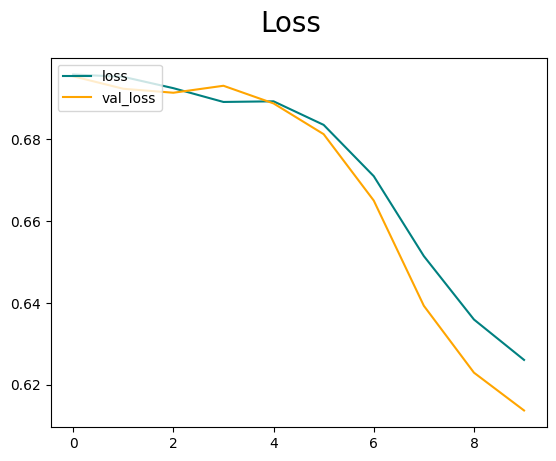

In [37]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

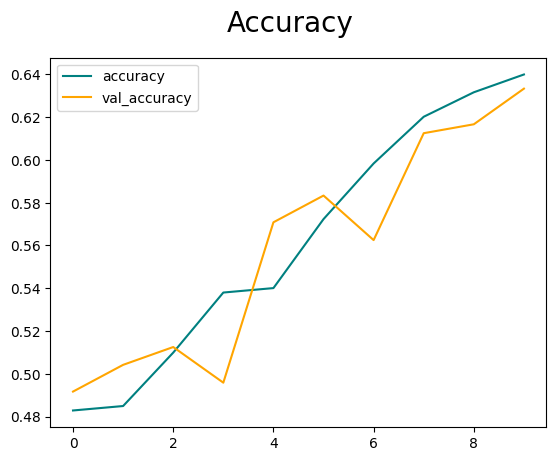

In [38]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

1/1 [==============================] - 0s 14ms/step


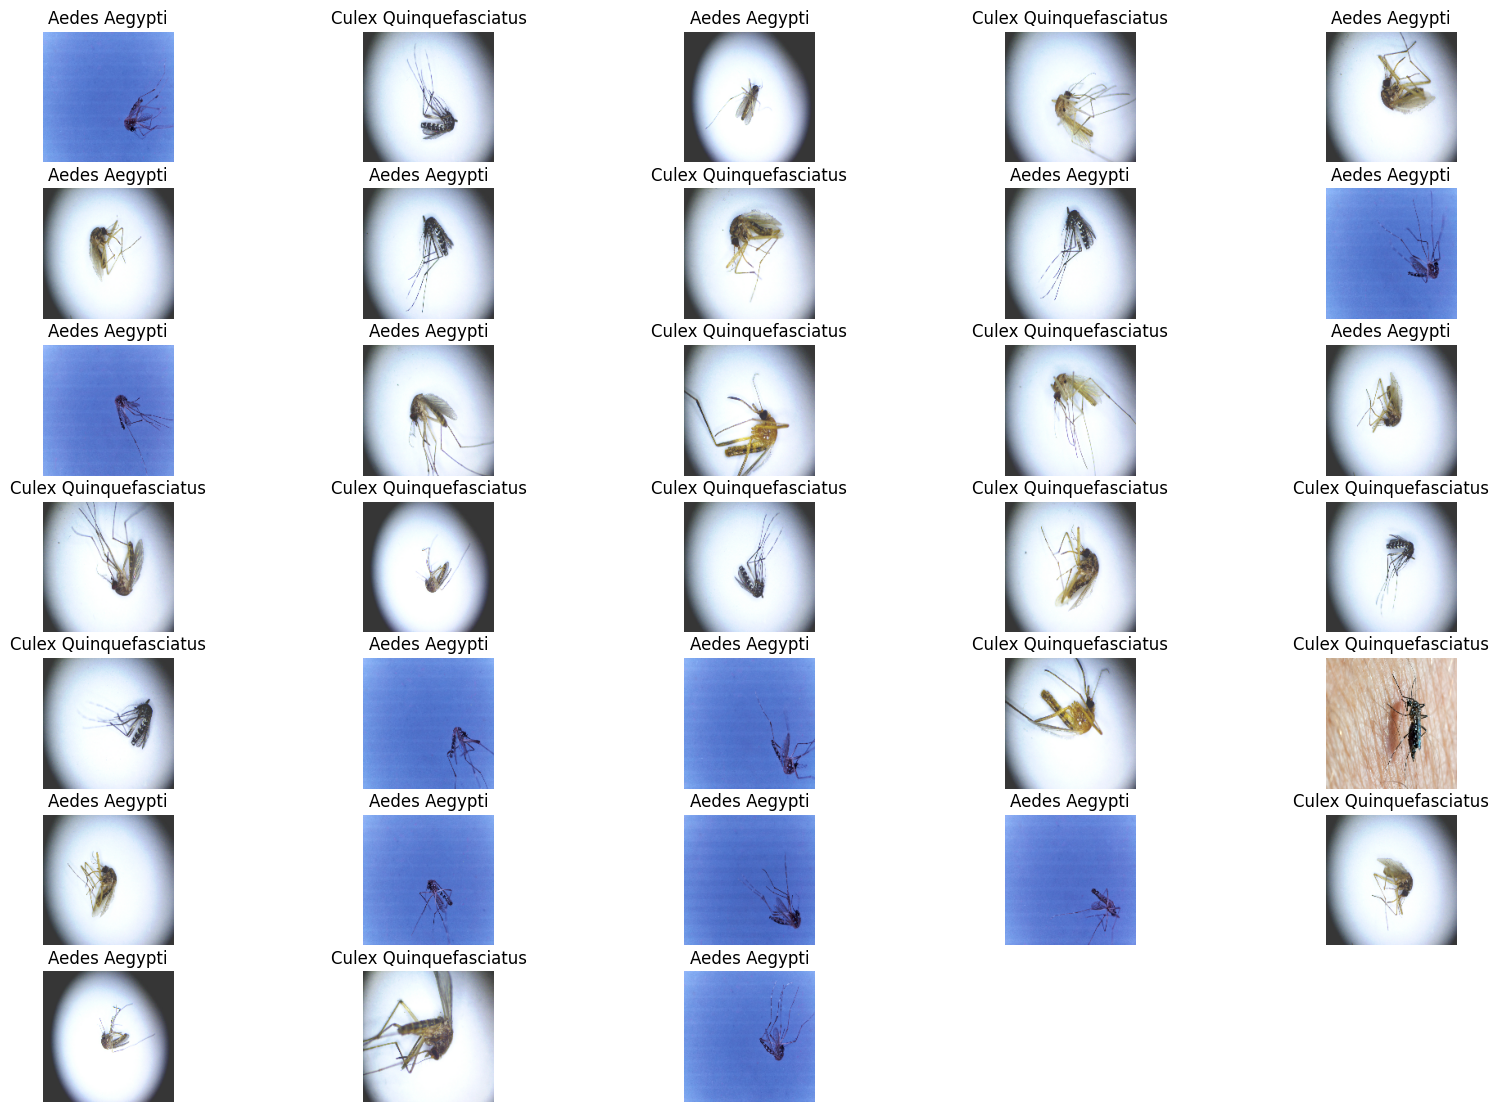

In [39]:
test_dir = os.path.join(root_dir, "test-dataset")
plt.figure(figsize=(20, 20))
for index, image in enumerate(os.listdir(test_dir)):
    img = cv2.imread(os.path.join(test_dir, image))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = tf.image.resize(img, IMG_SIZE)

    yhat = model.predict(np.expand_dims(img, 0))
    score = tf.nn.softmax(yhat[0])
    score = np.array(score)

    plt.subplot(10, 5, index + 1)
    plt.imshow(img.numpy().astype('uint8'))
    plt.title(class_names[np.argmax(score)])
    plt.axis("off")

In [40]:
model.save(os.path.join(root_dir, "models", "mosquitoes_model.keras"))